In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import  Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

2025-06-17 02:18:43.068634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750126723.305207      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750126723.379402      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
column_names = ['datetime','lat','lon','aqi','co','no','no2','o3','so2','pm2_5','pm10','nh3']
df = pd.read_csv('/kaggle/input/vietnam-aqi/data.csv',
                 names=column_names, 
                 header=None, 
                 parse_dates=["datetime"])

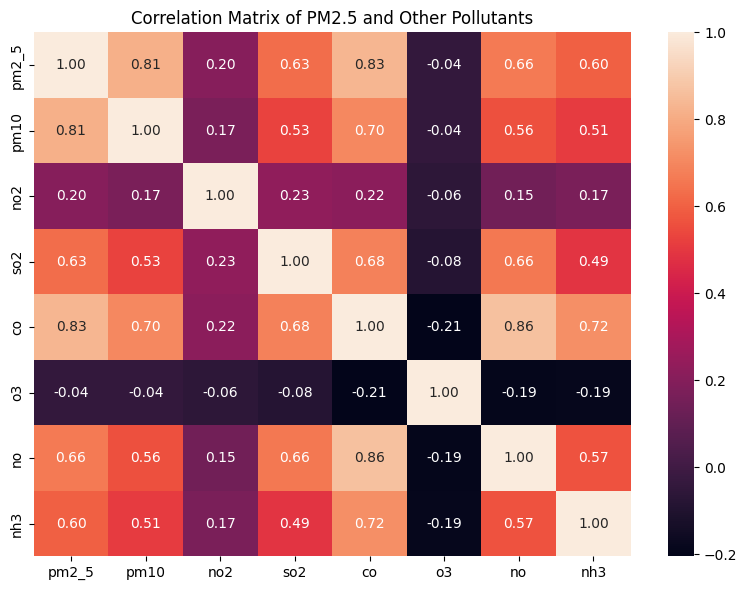

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named `df` and has these columns:
# ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3']

# Compute correlation matrix
corr_matrix = df[['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'no', 'nh3']].corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of PM2.5 and Other Pollutants')
plt.tight_layout()
plt.show()


In [4]:
df.loc[df["no2"] <= 0, "no2"] = df["no2"].median()
df.loc[df["pm10"] <= 0, "pm10"] = df["pm10"].median()
df.loc[df["pm2_5"] <= 0, "pm2_5"] = df["pm2_5"].median()
df.loc[df["o3"] <= 0, "o3"] = df["o3"].median()

In [5]:
df.isnull().sum()

datetime    0
lat         0
lon         0
aqi         0
co          0
no          0
no2         0
o3          0
so2         0
pm2_5       0
pm10        0
nh3         0
dtype: int64

In [6]:
df['datetime']=pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['date_num'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day_name()
df.drop('datetime',axis=1,inplace=True)

In [7]:
df['station'] = df[['lat', 'lon']].astype(str).agg('_'.join, axis=1)
df['station_id'] = df['station'].astype('category').cat.codes
# one_hot = pd.get_dummies(df['station_id'], prefix='station').astype(float)
# df = pd.concat([df, one_hot], axis=1)

In [8]:
df = df[df['station_id'] == 5]

In [9]:
df["co"] = df["co"] * 24.45 / (28.01 * 1000)
df["no2"] = df["no2"] * 24.45 / 46.01
df["so2"] = df["so2"] * 24.45 / 64.07
df["o3"] = df["o3"] * 24.45 / 48.00

In [10]:
# Calculate the AQI
def aqi_pm25(pm25):
    c = pm25
    conditions = [
        (c >= 0) & (c <= 12.0),
        (c > 12.0) & (c <= 35.4),
        (c > 35.4) & (c <= 55.4),
        (c > 55.4) & (c <= 150.4),
        (c > 150.4) & (c <= 250.4),
        (c > 250.4) & (c <= 350.4),
        (c > 350.4) & (c <= 500.4),
    ]
    values = [
        (c - 0)    * (50 - 0)    / (12.0 - 0)     + 0,
        (c - 12.1) * (100 - 51)  / (35.4 - 12.1)  + 51,
        (c - 35.5) * (150 - 101) / (55.4 - 35.5)  + 101,
        (c - 55.5) * (200 - 151) / (150.4 - 55.5) + 151,
        (c - 150.5)*(300 - 201) / (250.4 - 150.5) + 201,
        (c - 250.5)*(400 - 301) / (350.4 - 250.5) + 301,
        (c - 350.5)*(500 - 401) / (500.4 - 350.5) + 401,
    ]
    return np.select(conditions, values, default=np.nan)

def aqi_pm10(s):
    c = s
    conditions = [
        (c >= 0) & (c <= 54),
        (c > 54) & (c <= 154),
        (c > 154) & (c <= 254),
        (c > 254) & (c <= 354),
        (c > 354) & (c <= 424),
        (c > 424) & (c <= 504),
        (c > 504) & (c <= 604),
    ]
    values = [
        (c - 0)    * (50 - 0)    / (54 - 0)     + 0,
        (c - 55)   * (100 - 51)  / (154 - 55)   + 51,
        (c - 155)  * (150 - 101) / (254 - 155)  + 101,
        (c - 255)  * (200 - 151) / (354 - 255)  + 151,
        (c - 355)  * (300 - 201) / (424 - 355)  + 201,
        (c - 425)  * (400 - 301) / (504 - 425)  + 301,
        (c - 505)  * (500 - 401) / (604 - 505)  + 401,
    ]
    return np.select(conditions, values, default=np.nan)

def aqi_co(s):
    c = s
    conditions = [
        (c >= 0.0) & (c <= 4.4),
        (c > 4.4) & (c <= 9.4),
        (c > 9.4) & (c <= 12.4),
        (c > 12.4) & (c <= 15.4),
        (c > 15.4) & (c <= 30.4),
        (c > 30.4) & (c <= 40.4),
        (c > 40.4) & (c <= 50.4),
    ]
    values = [
        (c - 0.0)   * (50 - 0)    / (4.4 - 0.0)    + 0,
        (c - 4.5)   * (100 - 51)  / (9.4 - 4.5)    + 51,
        (c - 9.5)   * (150 - 101) / (12.4 - 9.5)   + 101,
        (c - 12.5)  * (200 - 151) / (15.4 - 12.5)  + 151,
        (c - 15.5)  * (300 - 201) / (30.4 - 15.5)  + 201,
        (c - 30.5)  * (400 - 301) / (40.4 - 30.5)  + 301,
        (c - 40.5)  * (500 - 401) / (50.4 - 40.5)  + 401,
    ]
    return np.select(conditions, values, default=np.nan)

def aqi_no2(s):
    c = s
    conditions = [
        (c >= 0) & (c <= 53),
        (c > 53) & (c <= 100),
        (c > 100) & (c <= 360),
        (c > 360) & (c <= 649),
        (c > 649) & (c <= 1249),
        (c > 1249) & (c <= 1649),
        (c > 1649) & (c <= 2049),
    ]
    values = [
        (c - 0)     * (50 - 0)    / (53 - 0)     + 0,
        (c - 54)    * (100 - 51)  / (100 - 54)   + 51,
        (c - 101)   * (150 - 101) / (360 - 101)  + 101,
        (c - 361)   * (200 - 151) / (649 - 361)  + 151,
        (c - 650)   * (300 - 201) / (1249 - 650) + 201,
        (c - 1250)  * (400 - 301) / (1649 - 1250)+ 301,
        (c - 1650)  * (500 - 401) / (2049 - 1650)+ 401,
    ]
    return np.select(conditions, values, default=np.nan)

def aqi_o3(s):
    c = s
    conditions = [
        (c >= 0) & (c <= 54),
        (c > 54) & (c <= 70),
        (c > 70) & (c <= 85),
        (c > 85) & (c <= 105),
        (c > 105) & (c <= 200),
    ]
    values = [
        (c - 0)   * (50 - 0)    / (54 - 0)     + 0,
        (c - 55)  * (100 - 51)  / (70 - 55)    + 51,
        (c - 71)  * (150 - 101) / (85 - 71)    + 101,
        (c - 86)  * (200 - 151) / (105 - 86)   + 151,
        (c - 106) * (300 - 201) / (200 - 106)  + 201,
    ]
    return np.select(conditions, values, default=np.nan)

def aqi_so2(s):
    c = s
    conditions = [
        (c >= 0) & (c <= 35),
        (c > 35) & (c <= 75),
        (c > 75) & (c <= 185),
        (c > 185) & (c <= 304),
        (c > 304) & (c <= 604),
        (c > 604) & (c <= 804),
        (c > 804) & (c <= 1004),
    ]
    values = [
        (c - 0)    * (50 - 0)    / (35 - 0)     + 0,
        (c - 36)   * (100 - 51)  / (75 - 36)    + 51,
        (c - 76)   * (150 - 101) / (185 - 76)   + 101,
        (c - 186)  * (200 - 151) / (304 - 186)  + 151,
        (c - 305)  * (300 - 201) / (604 - 305)  + 201,
        (c - 605)  * (400 - 301) / (804 - 605)  + 301,
        (c - 805)  * (500 - 401) / (1004 - 805) + 401,
    ]
    return np.select(conditions, values, default=np.nan)

In [11]:
df["aqi_pm25"] = aqi_pm25(df["pm2_5"])
df["aqi_pm10"] = aqi_pm10(df["pm10"])
df["aqi_co"] = aqi_pm10(df["co"])
df["aqi_no2"] = aqi_pm10(df["no2"])
df["aqi_o3"] = aqi_pm10(df["o3"])
df["aqi_so2"] = aqi_pm10(df["so2"])

df["aqi"] = df[["aqi_pm25", "aqi_pm10", "aqi_co", "aqi_no2", "aqi_o3", "aqi_so2"]].max(axis=1)

In [12]:
df = df.drop(["lon", "lat", "day","station"], axis=1)

In [13]:
df = df.drop(["aqi_pm25", "aqi_pm10", "aqi_co", "aqi_no2", "aqi_o3", "aqi_so2"], axis=1)

In [14]:
df = df.drop(["station_id","nh3","no2", 'o3', 'aqi'], axis=1)

In [15]:
df.head()

,co,no,so2,pm2_5,pm10,year,date_num,hour,month
0,0.978978,0.11,14.558569,70.68,86.48,2020,31,17,12
1,0.827468,0.06,13.100804,65.29,79.64,2020,31,18,12
2,0.740064,0.04,12.555096,63.35,76.71,2020,31,19,12
3,0.687620,0.05,12.555096,62.82,75.45,2020,31,20,12
4,0.646830,0.07,13.100804,62.48,74.61,2020,31,21,12


In [16]:
scaler = MinMaxScaler()

# Fit and transform the selected columns
columns_to_scale = ['co', 'no', 'so2', 'pm2_5', 'pm10']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df.head()

,co,no,so2,pm2_5,pm10,year,date_num,hour,month
0,0.070154,0.000308,0.141646,0.083273,0.090186,2020,31,17,12
1,0.057919,0.000168,0.127320,0.076693,0.082780,2020,31,18,12
2,0.050861,0.000112,0.121958,0.074325,0.079608,2020,31,19,12
3,0.046626,0.000140,0.121958,0.073678,0.078244,2020,31,20,12
4,0.043332,0.000196,0.127320,0.073262,0.077334,2020,31,21,12


In [17]:
df.head()

,co,no,so2,pm2_5,pm10,year,date_num,hour,month
0,0.070154,0.000308,0.141646,0.083273,0.090186,2020,31,17,12
1,0.057919,0.000168,0.127320,0.076693,0.082780,2020,31,18,12
2,0.050861,0.000112,0.121958,0.074325,0.079608,2020,31,19,12
3,0.046626,0.000140,0.121958,0.073678,0.078244,2020,31,20,12
4,0.043332,0.000196,0.127320,0.073262,0.077334,2020,31,21,12


In [18]:
def create_sequences(data, seq_length, target_col):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, target_col]  # Target is pollution
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 1
target_column_index = 3

X, y = create_sequences(df.values, seq_length, target_column_index)

# split into train and test sets:

train_size = int(len(X) * 0.8)  # Example: 80% for training
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print("Shape of training data X:", X_train.shape)
print("Shape of training data y:", y_train.shape)
print("Shape of testing data X:", X_test.shape)
print("Shape of testing data y:", y_test.shape)

Shape of training data X: (30645, 1, 9)
Shape of training data y: (30645,)
Shape of testing data X: (7662, 1, 9)
Shape of testing data y: (7662,)


In [19]:
# Build the GRU model

from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))  # Early Dropping
model.add(GRU(units=32))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

model.summary()

I0000 00:00:1750126739.319496      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 128)              │          53,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,961 (269.38 KB)

 Trainable params: 68,961 (269.38 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data= (X_test,y_test), callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1750126743.746370      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0421 - val_loss: 0.0151
Epoch 2/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0181 - val_loss: 0.0152
Epoch 3/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0158 - val_loss: 0.0147
Epoch 4/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 5/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0141 - val_loss: 0.0152
Epoch 6/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0105 - val_loss: 0.0035
Epoch 7/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 8/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 9/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 10/10
958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0039 - val_loss: 0.0019


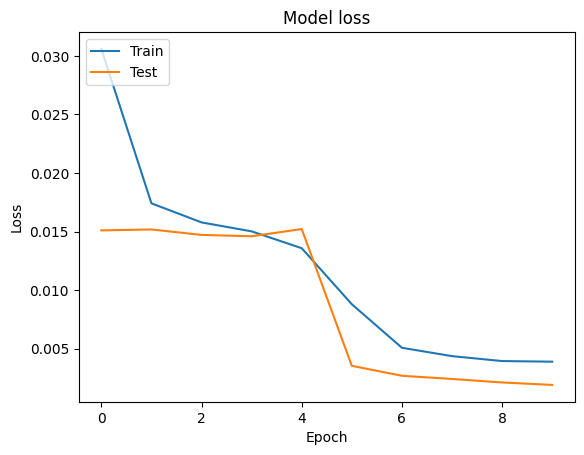

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.043452304608436645


In [23]:
# Find the index of the target column (e.g., 'pm2_5') in the scaled features
target_index = columns_to_scale.index('pm2_5')

# Inverse transform the predictions
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred_reshaped, np.zeros((len(y_pred_reshaped), len(columns_to_scale) - 1))], axis=1)
)[:, target_index]

# Inverse transform the actual values
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test_reshaped, np.zeros((len(y_test_reshaped), len(columns_to_scale) - 1))], axis=1)
)[:, target_index]

# Now you can use y_pred_rescaled and y_test_rescaled for evaluation
rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print('RMSE (Rescaled):', rmse)

NameError: name 'y_pred_reshaped' is not defined

In [ ]:
last_month_data = df.iloc[-744:]

# Get corresponding predictions and actual values
last_month_predictions = y_pred_rescaled[-744:]
last_month_actual = y_test_rescaled[-744:]


plt.figure(figsize=(12, 6))
plt.plot(last_month_actual, label='Actual')
plt.plot(last_month_predictions, label='Predicted')
plt.xlabel('Time Steps (last month)')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI (Last Month)')
plt.legend()
plt.show()

In [ ]:
#  plot test vs predicted for last week


# Get the last week's data (assuming your data is hourly)
last_week_data = df.iloc[-168:]  # Last 168 hours (24 hours/day * 7 days)


# Get corresponding predictions and actual values
last_week_predictions = y_pred_rescaled[-168:]
last_week_actual = y_test_rescaled[-168:]

plt.figure(figsize=(12, 6))
plt.plot(last_week_actual, label='Actual')
plt.plot(last_week_predictions, label='Predicted')
plt.xlabel('Time Steps (last week)')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI (Last Week)')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)